# Can I Predict the Amount of a Loan a Borrower Will Receive on Kiva?

Kiva is an international non-profit that hosts a crowdfunding platform that connects prospective borrowers with lenders to receive interest-free capital for loans of up to USD10,000 (or loans with interest above USD10,000). Kaggle, a platform that is home to machine learning open source data sets and competitions, hosted a "Data Science for Good" competition to generate some targeted machine learning models to predict information about loans and borrowers (https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding/data).


I decided to determine if I could predict the amount of a kiva loan based on certain information about the borrower and loan (e.g., poverty level, gender, etc.).  To answer this question, I used the kiva data provided from the Kaggle competition and collection some external data on poverty (United Nations Development Programme Human Development Index data) and on presence of armed conflicts in the location of the borrower (Armed Conflict Location and Event Database project data).

I applied several different machine learning models (decision tree, random forest, linear regression) to the data in my analysis  while trying to predict loan amounts below.  Please enjoy reading it and let me know if you have any questions.  There is still a lot to be done to tighten up these models, but this is my starting point as I continue to optimize my approach.

Have fun!

-Carole

## Data Sources

Kaggle-Kiva data from https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding/data
ACLED data from https://www.acleddata.com/data/
UNDP data and image from http://hdr.undp.org/en/content/human-development-index-hdi

## Some up-front cleaning of the data in Excel before I imported it here

- Gender: previously annotated as list delimited by commas with "male" or "female" in different orders, representing the different borrowers; I transposed the data into one column either identifying all borrowers as "male," "female," "both," or "not provided" (for n/a)
- Country Names: had to compare country names from loan data; if it was not included in the HDI list, examined the name and adjusted the spelling to match

- Timeframe: Loan and ACLED data is since 2014, spread out over several years. For UNDP HDI, I just took the HDI value for 2014.
- HDI Data: After some data cleaning to handle mismatched country spellings, I imported the HDI score for the borrower's country for every loan.
    - compared the country of the kiva borrower to UN list of Human Development Index (HDI) scores; inserted a column of the country's HDI score from 2014 (or the most recent score published by the UN, which was from 2008 for Kosovo, Somalia, the U.S. Virgin Islands, Guam, Puerto Rico, Cote D'Ivoire)
- ACLED Data: I compared the countries in the loan data with the countries listed in the ACLED database for having a conflict since 2014 (I was not sophisticated enough in my approach yet to handle comparing regions or latitude/longitude).  If the country location of the loan recipient had a conflict in the ACLED database, the value was coded "yes" ("no" if it did not).


# Read in and Examine the Data

In [1]:
#Read in data and import libraries
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
#kiva = pd.read_csv("C:\\Users\\carol\\Documents\\Dev\\Kiva_project\\Kiva_Crowdfunding_Analysis-master\\Kiva_projectdata.csv")
kiva = pd.read_csv('Kiva_projectdata.csv')

In [2]:
# Let's take a look
kiva.head()

,id,loan_amount,activity,sector,country,region,Conflict_ACLED,HumDevInd,partner_id,posted_time,term_in_months,lender_count,male_female,repayment_interval
0,653051,300,Fruits & Vegetables,Food,Pakistan,Lahore,yes,0.548,247.0,2014-01-01 06:12:39+00:00,12,12,female,irregular
1,653053,575,Rickshaw,Transportation,Pakistan,Lahore,yes,0.548,247.0,2014-01-01 06:51:08+00:00,11,14,female,irregular
2,653068,150,Transportation,Transportation,India,Maynaguri,yes,0.615,334.0,2014-01-01 09:58:07+00:00,43,6,female,bullet
3,653063,200,Embroidery,Arts,Pakistan,Lahore,yes,0.548,247.0,2014-01-01 08:03:11+00:00,11,8,female,irregular
4,653084,400,Milk Sales,Food,Pakistan,Abdul Hakeem,yes,0.548,245.0,2014-01-01 11:53:19+00:00,14,16,female,monthly


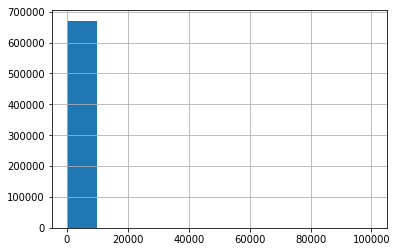

In [3]:
# Looking at the data distribution for loan amount - whew!  That's skewed!
kiva.loan_amount.hist()

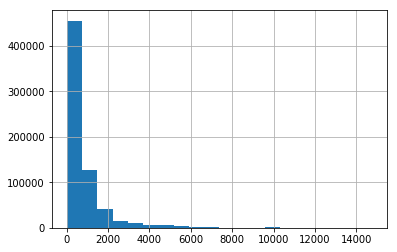

In [4]:
#Looking to see if any particular range of loans appears normally distributed and limits the skew/presence of outliers
kiva[kiva.loan_amount<15000].loan_amount.hist(bins=20)

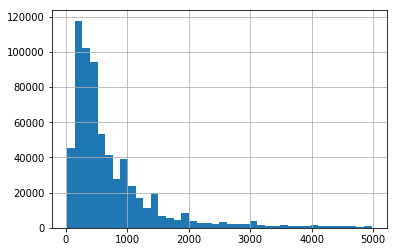

In [5]:
#Still looking.....
kiva[kiva.loan_amount<5000].loan_amount.hist(bins=40)

In [6]:
#Shows a signifciant skew of the loan amounts under $5,000; significant set of outliers above $1000-2000
kiva.skew()

id                 0.002125
loan_amount        9.795429
HumDevInd         -0.244906
partner_id         1.183399
term_in_months     3.725604
lender_count      13.801440
dtype: float64

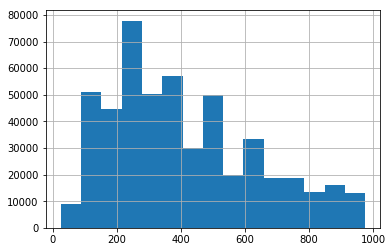

In [7]:
#Look at loans under $1000 - woohoo!  Still slightly skewed, but it's more normally distributed
kiva[kiva.loan_amount<1000].loan_amount.hist(bins=15)

In [117]:
#~75% of kiva loans granted are under $1000
under1000loan = (kiva[kiva.loan_amount<1000].loan_amount.count())/(kiva.loan_amount.count())
under1000loan

0.7489738604450206

In [83]:
#Restraining data set to loans under $1000; kiva is a platform for micro-loans; this model will work as a model for majority
#of loans for lenders looking to give small amounts of money to support individuals in impoverished areas
#There could potentially be external factors that change the nature of lending activity by lenders who loan more than $1000 or borrowers who are so successful that they get so many lenders and more money
kiva_1000 = kiva[kiva.loan_amount < 1000]
kiva_1000.describe()

,id,loan_amount,HumDevInd,partner_id,term_in_months,lender_count
count,5.027150e+05,502715.000000,502715.000000,494147.000000,502715.000000,502715.000000
mean,9.995999e+05,409.534130,0.622240,182.770332,12.596785,11.682351
std,1.964782e+05,225.723122,0.082936,91.135305,6.923955,7.777809
min,6.530480e+05,25.000000,0.364000,9.000000,1.000000,0.000000
25%,8.302530e+05,225.000000,0.550000,136.000000,8.000000,6.000000
50%,1.001998e+06,350.000000,0.678000,145.000000,12.000000,10.000000
75%,1.170200e+06,550.000000,0.679000,204.000000,14.000000,16.000000
max,1.340339e+06,975.000000,0.918000,533.000000,122.000000,85.000000


In [9]:
#While the data is still moderately skewed right for loan amount, the skew is significantly reduced
kiva_1000.skew()

id               -0.038332
loan_amount       0.650801
HumDevInd        -0.463174
partner_id        1.238515
term_in_months    3.707119
lender_count      0.890477
dtype: float64

In [10]:
kiva_1000.head()

,id,loan_amount,activity,sector,country,region,Conflict_ACLED,HumDevInd,partner_id,posted_time,term_in_months,lender_count,male_female,repayment_interval
0,653051,300,Fruits & Vegetables,Food,Pakistan,Lahore,yes,0.548,247.0,2014-01-01 06:12:39+00:00,12,12,female,irregular
1,653053,575,Rickshaw,Transportation,Pakistan,Lahore,yes,0.548,247.0,2014-01-01 06:51:08+00:00,11,14,female,irregular
2,653068,150,Transportation,Transportation,India,Maynaguri,yes,0.615,334.0,2014-01-01 09:58:07+00:00,43,6,female,bullet
3,653063,200,Embroidery,Arts,Pakistan,Lahore,yes,0.548,247.0,2014-01-01 08:03:11+00:00,11,8,female,irregular
4,653084,400,Milk Sales,Food,Pakistan,Abdul Hakeem,yes,0.548,245.0,2014-01-01 11:53:19+00:00,14,16,female,monthly


In [11]:
#Look at number of unique values per column
kiva_1000.nunique()

id                    502715
loan_amount               39
activity                 162
sector                    15
country                   76
region                  9616
Conflict_ACLED             2
HumDevInd                 70
partner_id               264
posted_time           500853
term_in_months            84
lender_count              73
male_female                4
repayment_interval         4
dtype: int64

In [84]:
#drop unnecessary columns; lender_count would be interesting but is similar to loan_amount, and loan_amount is what a borrower cares about
#dropped name of country because country and HDI have dependencies between each other; it isn't inherently the name of the country that is of interest but elements like HDI and ACLED that would impact desire for lenders to give funds
kiva_1000.drop(['id', 'activity', 'region', 'partner_id', 'posted_time', 'lender_count', 'country'], axis=1, inplace=True)

C:\Users\carol\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
kiva_1000.head()

,loan_amount,sector,Conflict_ACLED,HumDevInd,term_in_months,male_female,repayment_interval
0,300,Food,yes,0.548,12,female,irregular
1,575,Transportation,yes,0.548,11,female,irregular
2,150,Transportation,yes,0.615,43,female,bullet
3,200,Arts,yes,0.548,11,female,irregular
4,400,Food,yes,0.548,14,female,monthly


### Data Dictionary
- most column metadata taken from the kaggle data, additional data for the ACLED Conflict Data and Human Development Index

- loan_amount: The amount disbursed by the field agent to the borrower(USD)
- sector: High level category of type of activity the funding supported
- country: Full country name of country in which loan was disbursed
- Conflict_ACLED: Indicates where the country location of the loan borrower was in the ACLED database as being the location of an armed conflict since 2014
- HumDevInd: Indicates the UN Human Development Index, which integrates multiple factors (surround length and health of life, knowledge, and standard of living) to identify the overall development of a composite score for national development
- term_in_months: The duration for which the loan was disbursed in months
- lender_count: The total number of lenders that contributed to this loan
- male_female: Indicates genders of the borrowers; borrowers are categorized as all either male, female, or a mix of both genders (based on this binary categorization)
- repayment_interval: Indicates the type of interval over which the loan was paid back by the borrower

In [14]:
#This reflects the number of unique values per column.  Highlights that I can see what the unique sectors are, the 76 countries with recipients of loans, the different types of repayment intervals, and the different values for gender
kiva_1000.nunique()

loan_amount           39
sector                15
Conflict_ACLED         2
HumDevInd             70
term_in_months        84
male_female            4
repayment_interval     4
dtype: int64

In [15]:
#check the data types of the feature columns - we can see integer and float types as numerical variables, object as categorical variables
kiva_1000.dtypes

loan_amount             int64
sector                 object
Conflict_ACLED         object
HumDevInd             float64
term_in_months          int64
male_female            object
repayment_interval     object
dtype: object

In [16]:
#Check the nature of the values for each column

#These are the percentages of different sectors of loan activities for which kiva loans under $1,000 have been granted
kiva_1000.sector.value_counts(normalize=True)

Agriculture       0.265705
Food              0.206216
Retail            0.195522
Personal Use      0.064120
Services          0.061393
Housing           0.052638
Clothing          0.042648
Education         0.039651
Transportation    0.024579
Arts              0.017662
Health            0.011506
Manufacturing     0.008904
Construction      0.007925
Entertainment     0.000877
Wholesale         0.000654
Name: sector, dtype: float64

In [17]:
#These are the top 5 countries home to recipients of kiva loans under $1000, in rank order of the number of loans received
kiva[kiva.loan_amount <1000].country.value_counts(normalize=True).head()

Philippines    0.309493
Kenya          0.139900
El Salvador    0.059131
Cambodia       0.053307
Pakistan       0.050782
Name: country, dtype: float64

In [18]:
#These are the number of kiva loans under $1000 that went to a loan recipient in a country that was home to an armed conflict since 2014
kiva_1000.Conflict_ACLED.value_counts(normalize=True)

no     0.563856
yes    0.436144
Name: Conflict_ACLED, dtype: float64

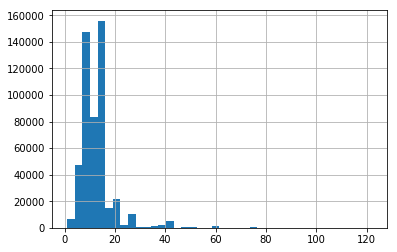

In [19]:
#This reflects that most kiva loans under $1000 are short-erm or under 20 months
kiva_1000.term_in_months.hist(bins=40)

In [20]:
#The majority of kiva loans under $1000 are granted to female borrowers
kiva_1000.male_female.value_counts(normalize=True)

female          0.770055
male            0.187758
both            0.036675
not provided    0.005512
Name: male_female, dtype: float64

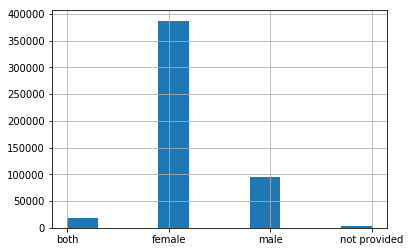

In [21]:
# Ladies dominate as kiva loan recipients
kiva_1000.male_female.hist()

In [22]:
#The majority of kiva loans under $1000 are almost evently split between monthly repayment plans and irregular repayment
kiva_1000.repayment_interval.value_counts(normalize=True)

monthly      0.459945
irregular    0.435163
bullet       0.103695
weekly       0.001197
Name: repayment_interval, dtype: float64

In [23]:
#Clean data, no null values, no need to drop any rows here
kiva_1000.isnull().sum()

loan_amount           0
sector                0
Conflict_ACLED        0
HumDevInd             0
term_in_months        0
male_female           0
repayment_interval    0
dtype: int64

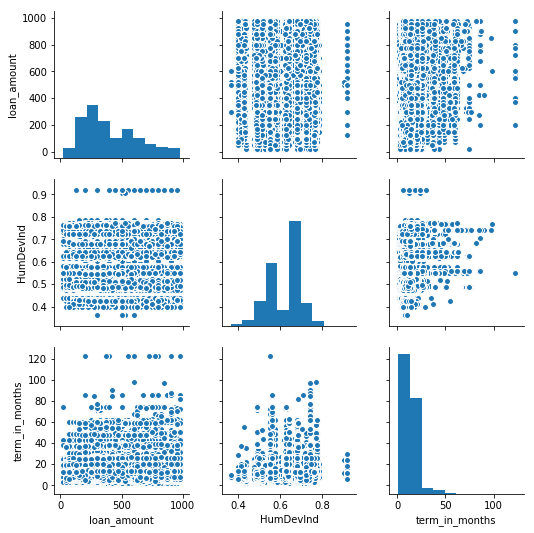

In [25]:
# plotting relationships between the different numerical variables.  Not a lot of obvious relationships that look easy to model.
sns.pairplot(kiva_1000)

# Prepare Data for Modeling

### Above, we had identified the following features as categorical variables:
- sector
- Conflict_ACLED
- male_female
- repayment_interval

I will factorize the unique values into numbers for use in regression modeling.

#### First, I must understand the different unique values for each categorical feature in order of their appearance
#### The values will be factorized in order of each unique values appearance

In [89]:
# Unique values as they appear in the sector feature
kiva_1000['sector'].groupby(kiva_1000['sector'], sort=False).count()

sector
Food              103668
Transportation     12356
Arts                8879
Services           30863
Agriculture       133574
Manufacturing       4476
Wholesale            329
Retail             98292
Clothing           21440
Construction        3984
Health              5784
Education          19933
Personal Use       32234
Housing            26462
Entertainment        441
Name: sector, dtype: int64

In [90]:
# Unique values as they appear in the Conflict_ACLED feature
kiva_1000['Conflict_ACLED'].groupby(kiva_1000['Conflict_ACLED'], sort=False).count()

Conflict_ACLED
yes    219256
no     283459
Name: Conflict_ACLED, dtype: int64

In [91]:
# Unique values as they appear in the male_female feature
kiva_1000['male_female'].groupby(kiva_1000['male_female'], sort=False).count()

male_female
female          387118
male             94389
both             18437
not provided      2771
Name: male_female, dtype: int64

In [92]:
# Unique values as they appear in the repayment_interval feature
kiva_1000['repayment_interval'].groupby(kiva_1000['repayment_interval'], sort=False).count()

repayment_interval
irregular    218763
bullet        52129
monthly      231221
weekly          602
Name: repayment_interval, dtype: int64

In [93]:
# Encode categorical variables as integers.
kiva_1000['sector'] = pd.factorize(kiva_1000.sector)[0]
kiva_1000['Conflict_ACLED'] = pd.factorize(kiva_1000.Conflict_ACLED)[0]
kiva_1000['male_female'] = pd.factorize(kiva_1000.male_female)[0]
kiva_1000['repayment_interval'] = pd.factorize(kiva_1000.repayment_interval)[0]
kiva_1000.head()

C:\Users\carol\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\carol\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\carol\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,loan_amount,sector,Conflict_ACLED,HumDevInd,term_in_months,male_female,repayment_interval
0,300,0,0,0.548,12,0,0
1,575,1,0,0.548,11,0,0
2,150,1,0,0.615,43,0,1
3,200,2,0,0.548,11,0,0
4,400,0,0,0.548,14,0,2


# MODELS (DECISION TREE, RANDOM FOREST, LINEAR REGRESSION)

# Decision Tree

In [75]:
#Define my features
feature_cols = kiva_1000.columns.drop('loan_amount')
feature_cols

Index(['sector', 'Conflict_ACLED', 'HumDevInd', 'term_in_months',
       'male_female', 'repayment_interval'],
      dtype='object')

In [76]:
# Define X and y.
X = kiva_1000[feature_cols]
y = kiva_1000.loan_amount

In [77]:
#Make my Decision Tree

from sklearn.tree import DecisionTreeRegressor

# Grow each tree deep.
treereg = DecisionTreeRegressor(max_depth=None, random_state=124)

#use cross-validation to find optimal depth of a decision tree
# List of values to try for max_depth:
max_depth_range = list(range(1, 21))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

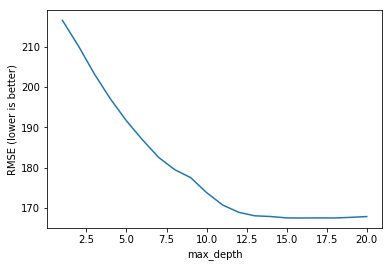

In [78]:
# Looking for optimum max depth of the tree - wow, 16 steps is deep!
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [79]:
sorted(zip(RMSE_scores, max_depth_range))[0]

(167.55196996615499, 16)

In [80]:
# max_depth=16 was best to minimize RMSE, however, that will limit interpretability and manageability for users of the model
# Reduced the max_depth parameter to 3; Next steps could continue to optimize to reduce error
treereg = DecisionTreeRegressor(max_depth=3, random_state=42)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [35]:
# Create a Graphviz file and generate an image of the decision tree
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_kiva.dot', feature_names=feature_cols)

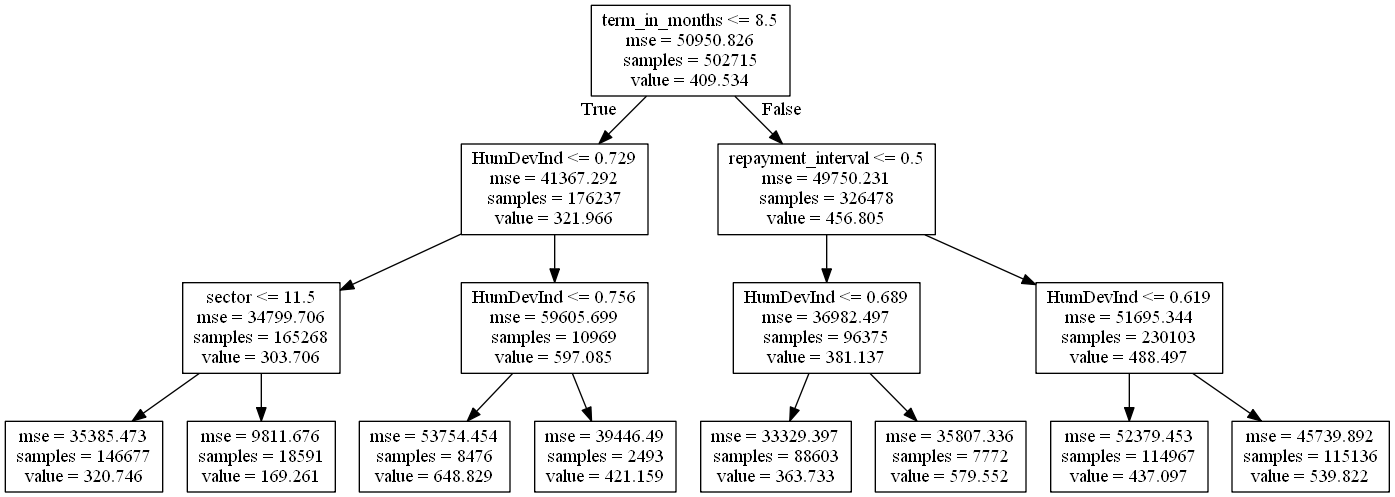

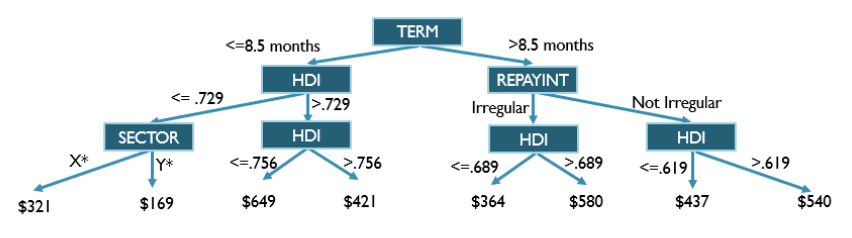

In [81]:
# Compute feature importances in decision tree.  We see that conflict value and gender of the borrowers did not factor at all into the splits of this model
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values(by='importance')

,feature,importance
1,Conflict_ACLED,0.000000
4,male_female,0.000000
0,sector,0.073272
5,repayment_interval,0.151506
2,HumDevInd,0.372528
3,term_in_months,0.402695


In [82]:
# Determine the RMSE of this model
scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

202.9983494983402

# Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
# max_features=5 (i.e., number of features used) is best and n_estimators=150 (i.e., number of used trees) is sufficiently large.
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=42)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [39]:
# Compute the out-of-bag R-squared score.
print((rfreg.oob_score_))

# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.49209367969321693


166.27278509198067

## Determine most important features

In [40]:
# Compute feature importances in random forest.
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
1,Conflict_ACLED,0.026388
4,male_female,0.067730
5,repayment_interval,0.090547
0,sector,0.114006
3,term_in_months,0.302581
2,HumDevInd,0.398749


In [41]:
# Check the shape of X.
X.shape

(502715, 6)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 17)

In [43]:
# Fit the model on only the train data
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=2)
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=True, random_state=2,
           verbose=0, warm_start=False)

In [44]:
# Set a threshold for which features to include.
from sklearn.feature_selection import SelectFromModel

print(SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_train).shape)
print(SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train).shape)

(377036, 2)
(377036, 3)


In [45]:
# Create matrix with only important features.  I chose to include through the median number of variables based on importance score.

X_important =  SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_test)

In [46]:
# Check the RMSE for a random forest that only includes my important features.
#RMSE increased slightly from the out-of-the-box value of the RF model, but it is slightly lower error that the decision tree model
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)

scores = cross_val_score(rfreg, X_important, y_test, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

167.6446910752821

## Tuning Random Forest Model Parameters

### Here, I attempted to optimize my random forest model integrating all features

In [47]:
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
#I'm going to begin by trying to optimize for the number of n_estimators (i.e., the number of trees in my forest)

# List of values to try for n_estimators:
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Used five-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

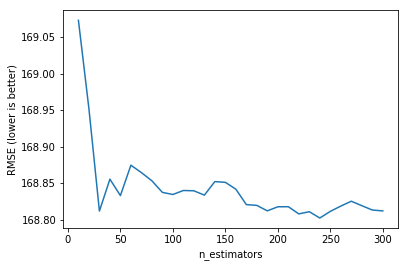

In [49]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

In [50]:
# Now let's look at the optimum number of max features to be considered at each split

# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Used 5-fold cross-validation with each value of max_features.
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=240, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

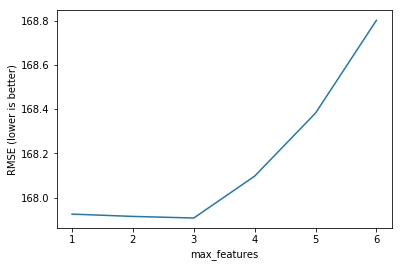

In [51]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [52]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, feature_range))[0]

(167.90763468098788, 3)

## Optimized Random Forest Model

### Tuning a new Random Forest model for Optimized/most important features

In [53]:
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [54]:
# Let's optimize for the number of trees in my forest

# List of values to try for n_estimators:
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Defining features to be only the most important ones, as determined above (under "determine most important features")
feature_cols_rf_opt = feature_cols.drop(['Conflict_ACLED', 'male_female', 'repayment_interval'])
X_rf_opt = kiva_1000[feature_cols_rf_opt]

# Used five-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X_rf_opt, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

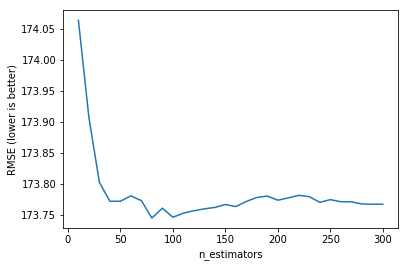

In [55]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

#### At approximately 80 estimators, the RMSE appears to be minimized.

In [56]:
# Altered n_estimators based on optimal finding above
# Now let's look for the optimum number of maximum features at each split

# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Used 5-fold cross-validation with each value of max_features.
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=80, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

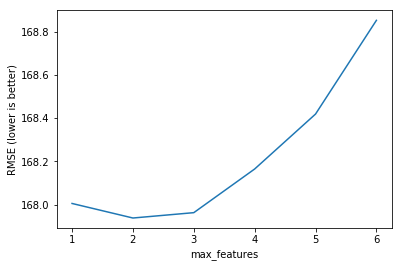

In [57]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [58]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, feature_range))[0]

(167.93758006489367, 2)

In [59]:
# Must redo train-test-split to fit model on new train and test data since we adjusted X to only the most important features

from sklearn.model_selection import train_test_split

#restating X for clarity and designating y
X_rf_opt = kiva_1000[feature_cols_rf_opt]
y = kiva_1000.loan_amount

X_train, X_test, y_train, y_test = train_test_split(X_rf_opt,y, random_state = 17)

In [60]:
#Run new RF on train data considering only my most important variables and integrating optimal estimator and max_feature #

rfreg = RandomForestRegressor(n_estimators=80, max_features=2, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [61]:
#Check the RMSE for the optimized RF model on the new test data

scores = cross_val_score(rfreg, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

167.59830753487122

# Linear Regression

## LR1. Out-of-the-box Linear Regression Models

### LinReg of all features independently in predicting loan amount

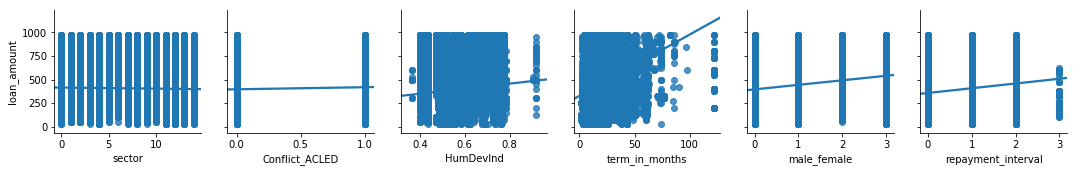

In [62]:
#All three attributes in separate plots as the variables impacting price
#Nothing here really looks promising in correlation values
sns.pairplot(kiva_1000, x_vars=feature_cols, y_vars='loan_amount', kind='reg')

In [63]:
#Again, we see pretty low correlation values between single features
kiva_1000.corr()

,loan_amount,sector,Conflict_ACLED,HumDevInd,term_in_months,male_female,repayment_interval
loan_amount,1.000000,-0.020049,0.048793,0.098333,0.199354,0.118035,0.210848
sector,-0.020049,1.000000,-0.072713,-0.003629,0.166712,0.123079,0.192909
Conflict_ACLED,0.048793,-0.072713,1.000000,0.784367,-0.123552,-0.141630,-0.289724
HumDevInd,0.098333,-0.003629,0.784367,1.000000,0.011104,-0.140378,-0.206956
term_in_months,0.199354,0.166712,-0.123552,0.011104,1.000000,0.037961,0.220844
male_female,0.118035,0.123079,-0.141630,-0.140378,0.037961,1.000000,0.224889
repayment_interval,0.210848,0.192909,-0.289724,-0.206956,0.220844,0.224889,1.000000


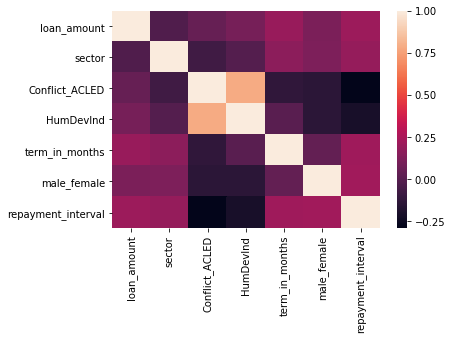

In [64]:
#Yep, low correlation between most features
sns.heatmap(kiva_1000.corr());

#### Generally, we see low correlation between any particular feature and the loan amount.  There are also pretty low correlations between any other features except the ACLED conflict data and the Human Development Index.

### LinReg of all features combined to predict loan amount

In [65]:
#Build a linear regression considering all features to predict loan

from sklearn.linear_model import LinearRegression

# Create X and y.
Xcombined = kiva_1000[feature_cols]
ycombined = kiva_1000.loan_amount

# Instantiate and fit linear regression model.
linreg = LinearRegression()
linreg.fit(Xcombined, ycombined)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

94.28242213976756
[ -5.50933159  19.97189705 322.46673122   5.5477844   40.68356929
  49.21510935]


## LR2. Train-Test-Split to Generate a Linear Regression Model

### Testing Null: For comparison with final model, will generate null RMSE to see if the model improves upon predicting mean values

In [66]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [67]:
# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test.
y_null.fill(y_test.mean())
y_null

array([409.89564685, 409.89564685, 409.89564685, ..., 409.89564685,
       409.89564685, 409.89564685])

In [68]:
# Compute null RMSE.
np.sqrt(metrics.mean_squared_error(y_test, y_null))

225.73406252008544

### Generate Linear Regression

#### Find most important features

In [96]:
#Import Recursive Feature Elimination through scikitlearn to be able to identify the attribute that contribute most to predicting the target value
from sklearn.feature_selection import RFE
lingreg= LinearRegression()

In [97]:
#Call recursive feature elimination looking for the top feature; will output the ranking of all the features

#define data
X = kiva_1000[feature_cols]
y = kiva_1000.loan_amount

#feature extraction
rfe=RFE(linreg, 1)
fit=rfe.fit(X,y)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 1
Selected Features: [False False  True False False False]
Feature Ranking: [6 4 1 5 3 2]


In [98]:
# Call feature_cols to see the features in order of correlation
# We see that the order of important features is:
#1. Human Development Index
#2. Repayment Interval
#3. Male or female designation of borrowers
#4. Conflict presence (ACLED data)
#5. Term length in months
#6. Sector of the activity
feature_cols

Index(['sector', 'Conflict_ACLED', 'HumDevInd', 'term_in_months',
       'male_female', 'repayment_interval'],
      dtype='object')

#### Create Model, Use Train-Test-Split

In [99]:
# Define a function that accepts a list of features and returns testing RMSE; stayed with default train-test-split of 75% train, 25% test
def train_test_rmse(kiva_1000, feature_cols):
    X = kiva_1000[feature_cols]
    y = kiva_1000.loan_amount
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg.fit(X_train, y_train) #fits the linear regression to the training data
    
    y_pred = linreg.predict(X_test) #generates predictions against the test data
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [100]:
# printing the RMSE for several different combinations of features, dropping off variables in reverse order of importance (RFE-determined)
print (train_test_rmse(kiva_1000, ['term_in_months', 'HumDevInd', 'sector', 'repayment_interval', 'male_female', 'Conflict_ACLED']))
print (train_test_rmse(kiva_1000, ['term_in_months', 'HumDevInd', 'repayment_interval', 'male_female', 'Conflict_ACLED']))
print (train_test_rmse(kiva_1000, ['HumDevInd', 'repayment_interval', 'male_female', 'Conflict_ACLED']))
print (train_test_rmse(kiva_1000, ['HumDevInd', 'repayment_interval', 'male_female']))
print (train_test_rmse(kiva_1000, ['HumDevInd', 'repayment_interval']))
print (train_test_rmse(kiva_1000, ['HumDevInd']))


213.69826116707014
214.72021020558373
217.34654170312072
217.3503658507454
218.26384827167746
224.69998783157735


In [104]:
#Developed a linear regression for the "most important features" based on RFE

feature_cols_lr_imprtfeat = feature_cols.drop(['Conflict_ACLED', 'sector', 'term_in_months'])
X_lr_opt = kiva_1000[feature_cols_lr_imprtfeat]
ycombined = kiva_1000.loan_amount

# Instantiate and fit linear regression model.
linreg = LinearRegression()
linreg.fit(X_lr_opt, ycombined)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

print (train_test_rmse(kiva_1000, feature_cols_lr_imprtfeat))

78.68669649330866
[427.6721267   36.62922403  53.11924621]
217.35036585074536


77.76173104942279
[428.9804039   36.42711012  53.09877667]
217.35036585074536


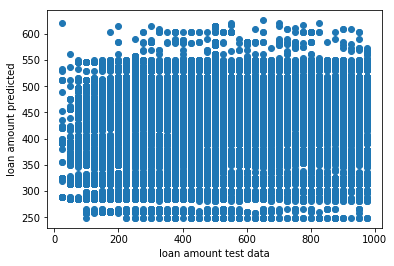

In [113]:
#Developed a linear regression for the "most important features" based on RFE, do a train-test-split method to develop/score the model

feature_cols_lr_imprtfeat = feature_cols.drop(['Conflict_ACLED', 'sector', 'term_in_months'])
X_lr_opt = kiva_1000[feature_cols_lr_imprtfeat]

def train_test_rmse(kiva_1000, feature_cols):
    X = X_lr_opt
    y = kiva_1000.loan_amount
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg.fit(X_train, y_train) #fits the linear regression to the training data
    
    y_pred = linreg.predict(X_test) #generates predictions against the test data
    
    plt.scatter(y_test, y_pred) #plots the test data loan amount versus the predicted loan amount from the model
    plt.xlabel('loan amount test data')
    plt.ylabel('loan amount predicted')
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

print (train_test_rmse(kiva_1000, feature_cols_lr_imprtfeat))


### Yikes, that is not a great distribution for test loan amount information versus predicted loan amount.  Linear regression may not be the best choice here.